<a href="https://colab.research.google.com/github/Aksavxavier/Aksa-Villamthanam-Xavier/blob/main/FEM_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Linear elastic FE formulation for the mechanical problem

## Problem Description

 To Solve a 2D linear elastic problem under small strain assumptions. The goal is to compute the displacement field and stress distribution for a given geometry, material properties, and boundary conditions.

## Steps in Linear Elastic FE Formulation

1. Governing Equations:

Equilibrium equation: ∇⋅σ+f=0

Constitutive law (Hooke’s law): σ=C:ϵ

Strain-displacement relationship

2. Weak Form:
Multiply the equilibrium equation by a test function
v
and integrate over the domain.
Apply integration by parts to derive the weak form.

3. Discretization:
Discretize the domain into finite elements (e.g., triangles or quadrilaterals in 2D).
Approximate the displacement field using shape functions.

4. Assembly:
Assemble the global stiffness matrix and force vector.
Apply boundary conditions.

5. Solution:
Solve the system of linear equations to obtain nodal displacements.
Compute strains and stresses from displacements.



# Example Problem

A 1x1 square domain is fixed at the bottom-left corner.

A horizontal force is applied at the top-right corner.

The displacement field and stress distribution are computed and visualized.


# Features of JAX for FEA

Automatic Differentiation:
JAX can compute derivatives automatically, which is useful for computing the Jacobian and strain-displacement matrix.

GPU Acceleration:
JAX can run computations on GPUs, making it highly efficient for large-scale problems.

Functional Programming:
JAX encourages a functional programming style, which is well-suited for numerical computations.


Steps in Linear Elastic FE Formulation

Governing Equations:
Equilibrium equation:∇⋅σ+f=0

Constitutive law (Hooke’s law): σ=C:ϵ

Strain-displacement relationship

Weak Form:
Multiply the equilibrium equation by a test function
v
v and integrate over the domain.
Apply integration by parts to derive the weak form.

Discretization:
Discretize the domain into finite elements (e.g., triangles or quadrilaterals in 2D).
Approximate the displacement field using shape functions.

Assembly:
Assemble the global stiffness matrix and force vector.
Apply boundary conditions.

Solution:
Solve the system of linear equations to obtain nodal displacements.
Compute strains and stresses from displacements.


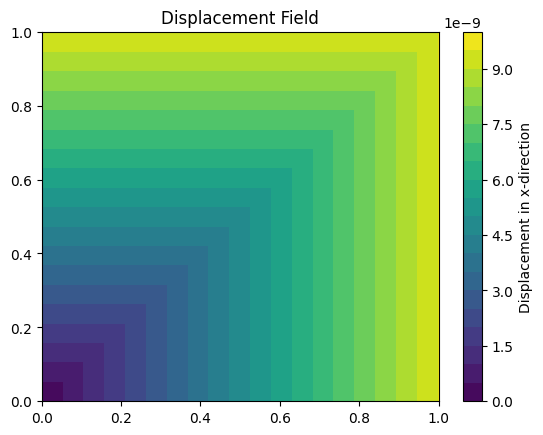

In [6]:
import jax
import jax.numpy as jnp
from jax import lax, vmap
from jax.scipy.linalg import solve
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# Enable 64-bit precision for JAX
jax.config.update("jax_enable_x64", True)

# Material properties
E = 210e9  # Young's modulus (Pa)
nu = 0.3   # Poisson's ratio

# Plane stress constitutive matrix
C = (E / (1 - nu**2)) * jnp.array([
    [1, nu, 0],
    [nu, 1, 0],
    [0, 0, (1 - nu) / 2]
])

# Define a simple mesh (nodes and elements)
nodes = jnp.array([
    [0, 0],
    [1, 0],
    [1, 1],
    [0, 1]
])

elements = jnp.array([
    [0, 1, 2],
    [0, 2, 3]
])

# Number of nodes and elements
num_nodes = nodes.shape[0]
num_elements = elements.shape[0]

# Initialize global stiffness matrix and force vector
K = jnp.zeros((2 * num_nodes, 2 * num_nodes))
F = jnp.zeros(2 * num_nodes)

# Shape functions and derivatives for a linear triangle
def shape_functions(xi, eta):
    N = jnp.array([1 - xi - eta, xi, eta])
    dN = jnp.array([
        [-1, -1],
        [1, 0],
        [0, 1]
    ])
    return N, dN

# Gauss quadrature points and weights
gauss_points = jnp.array([[1/3, 1/3]])
gauss_weights = jnp.array([0.5])

# Function to compute element stiffness matrix
def element_stiffness(node_ids, x):
    Ke = jnp.zeros((6, 6))

    for gp in gauss_points:
        xi, eta = gp
        N, dN = shape_functions(xi, eta)

        # Jacobian matrix
        J = dN.T @ x
        detJ = jnp.linalg.det(J)
        invJ = jnp.linalg.inv(J)

        # Derivatives of shape functions with respect to global coordinates
        dN_dx = dN @ invJ

        # Strain-displacement matrix (B)
        B = jnp.zeros((3, 6))
        B = B.at[0, 0::2].set(dN_dx[:, 0])  # du/dx
        B = B.at[1, 1::2].set(dN_dx[:, 1])  # dv/dy
        B = B.at[2, 0::2].set(dN_dx[:, 1])  # du/dy
        B = B.at[2, 1::2].set(dN_dx[:, 0])  # dv/dx

        # Element stiffness matrix
        Ke += B.T @ C @ B * detJ * gauss_weights[0]

    return Ke

# Assemble the global stiffness matrix
for e in range(num_elements):
    node_ids = elements[e]
    x = nodes[node_ids]
    Ke = element_stiffness(node_ids, x)

    # Assemble into global stiffness matrix
    for i in range(3):
        for j in range(3):
            K = K.at[2*node_ids[i]:2*node_ids[i]+2, 2*node_ids[j]:2*node_ids[j]+2].add(Ke[2*i:2*i+2, 2*j:2*j+2])

# Apply boundary conditions (fixed at node 0, force at node 2)
F = F.at[4].set(1000)  # Force in x-direction at node 2
fixed_dofs = [0, 1]  # Fix node 0 in x and y directions

# Modify stiffness matrix and force vector for boundary conditions
for dof in fixed_dofs:
    K = K.at[dof, :].set(0)
    K = K.at[:, dof].set(0)
    K = K.at[dof, dof].set(1)
    F = F.at[dof].set(0)

# Solve for displacements
U = solve(K, F)

# Post-processing: Compute strains and stresses
stresses = []
for e in range(num_elements):
    node_ids = elements[e]
    x = nodes[node_ids]

    # Extract displacements for the element (6 DOFs: u1, v1, u2, v2, u3, v3)
    Ue = jnp.zeros(6)
    for i in range(3):
        Ue = Ue.at[2*i].set(U[2*node_ids[i]])      # u displacement
        Ue = Ue.at[2*i+1].set(U[2*node_ids[i]+1])  # v displacement

    xi, eta = gauss_points[0]
    N, dN = shape_functions(xi, eta)

    # Jacobian matrix
    J = dN.T @ x
    detJ = jnp.linalg.det(J)
    invJ = jnp.linalg.inv(J)

    # Derivatives of shape functions with respect to global coordinates
    dN_dx = dN @ invJ

    # Strain-displacement matrix (B)
    B = jnp.zeros((3, 6))
    B = B.at[0, 0::2].set(dN_dx[:, 0])  # du/dx
    B = B.at[1, 1::2].set(dN_dx[:, 1])  # dv/dy
    B = B.at[2, 0::2].set(dN_dx[:, 1])  # du/dy
    B = B.at[2, 1::2].set(dN_dx[:, 0])  # dv/dx

    # Compute strain and stress
    strain = B @ Ue
    stress = C @ strain
    stresses.append(stress)

# Plot the results
triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)
plt.tricontourf(triangulation, U[::2], levels=20, cmap='viridis')
plt.colorbar(label='Displacement in x-direction')
plt.title('Displacement Field')
plt.show()

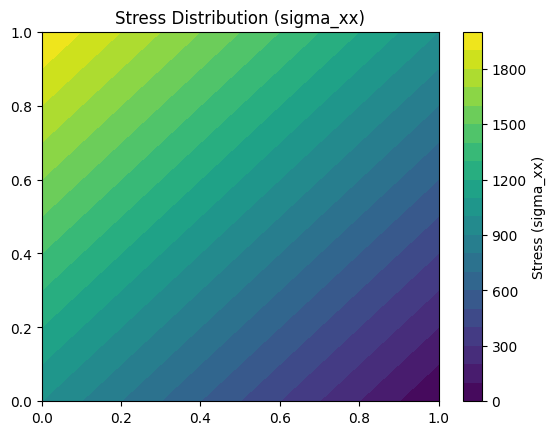

In [7]:
import jax
import jax.numpy as jnp
from jax.scipy.linalg import solve
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# Enable 64-bit precision for JAX
jax.config.update("jax_enable_x64", True)

# Material properties
E = 210e9  # Young's modulus (Pa)
nu = 0.3   # Poisson's ratio

# Plane stress constitutive matrix
C = (E / (1 - nu**2)) * jnp.array([
    [1, nu, 0],
    [nu, 1, 0],
    [0, 0, (1 - nu) / 2]
])

# Define a simple mesh (nodes and elements)
nodes = jnp.array([
    [0, 0],
    [1, 0],
    [1, 1],
    [0, 1]
])

elements = jnp.array([
    [0, 1, 2],
    [0, 2, 3]
])

# Number of nodes and elements
num_nodes = nodes.shape[0]
num_elements = elements.shape[0]

# Initialize global stiffness matrix and force vector
K = jnp.zeros((2 * num_nodes, 2 * num_nodes))
F = jnp.zeros(2 * num_nodes)

# Shape functions and derivatives for a linear triangle
def shape_functions(xi, eta):
    N = jnp.array([1 - xi - eta, xi, eta])
    dN = jnp.array([
        [-1, -1],
        [1, 0],
        [0, 1]
    ])
    return N, dN

# Gauss quadrature points and weights
gauss_points = jnp.array([[1/3, 1/3]])
gauss_weights = jnp.array([0.5])

# Function to compute element stiffness matrix
def element_stiffness(node_ids, x):
    Ke = jnp.zeros((6, 6))

    for gp in gauss_points:
        xi, eta = gp
        N, dN = shape_functions(xi, eta)

        # Jacobian matrix
        J = dN.T @ x
        detJ = jnp.linalg.det(J)
        invJ = jnp.linalg.inv(J)

        # Derivatives of shape functions with respect to global coordinates
        dN_dx = dN @ invJ

        # Strain-displacement matrix (B)
        B = jnp.zeros((3, 6))
        B = B.at[0, 0::2].set(dN_dx[:, 0])  # du/dx
        B = B.at[1, 1::2].set(dN_dx[:, 1])  # dv/dy
        B = B.at[2, 0::2].set(dN_dx[:, 1])  # du/dy
        B = B.at[2, 1::2].set(dN_dx[:, 0])  # dv/dx

        # Element stiffness matrix
        Ke += B.T @ C @ B * detJ * gauss_weights[0]

    return Ke

# Assemble the global stiffness matrix
for e in range(num_elements):
    node_ids = elements[e]
    x = nodes[node_ids]
    Ke = element_stiffness(node_ids, x)

    # Assemble into global stiffness matrix
    for i in range(3):
        for j in range(3):
            K = K.at[2*node_ids[i]:2*node_ids[i]+2, 2*node_ids[j]:2*node_ids[j]+2].add(Ke[2*i:2*i+2, 2*j:2*j+2])

# Apply boundary conditions (fixed at node 0, force at node 2)
F = F.at[4].set(1000)  # Force in x-direction at node 2
fixed_dofs = [0, 1]  # Fix node 0 in x and y directions

# Modify stiffness matrix and force vector for boundary conditions
for dof in fixed_dofs:
    K = K.at[dof, :].set(0)
    K = K.at[:, dof].set(0)
    K = K.at[dof, dof].set(1)
    F = F.at[dof].set(0)

# Solve for displacements
U = solve(K, F)

# Post-processing: Compute stresses at Gauss points
stresses_at_gauss = []
for e in range(num_elements):
    node_ids = elements[e]
    x = nodes[node_ids]

    # Extract displacements for the element (6 DOFs: u1, v1, u2, v2, u3, v3)
    Ue = jnp.zeros(6)
    for i in range(3):
        Ue = Ue.at[2*i].set(U[2*node_ids[i]])      # u displacement
        Ue = Ue.at[2*i+1].set(U[2*node_ids[i]+1])  # v displacement

    xi, eta = gauss_points[0]
    N, dN = shape_functions(xi, eta)

    # Jacobian matrix
    J = dN.T @ x
    detJ = jnp.linalg.det(J)
    invJ = jnp.linalg.inv(J)

    # Derivatives of shape functions with respect to global coordinates
    dN_dx = dN @ invJ

    # Strain-displacement matrix (B)
    B = jnp.zeros((3, 6))
    B = B.at[0, 0::2].set(dN_dx[:, 0])  # du/dx
    B = B.at[1, 1::2].set(dN_dx[:, 1])  # dv/dy
    B = B.at[2, 0::2].set(dN_dx[:, 1])  # du/dy
    B = B.at[2, 1::2].set(dN_dx[:, 0])  # dv/dx

    # Compute strain and stress
    strain = B @ Ue
    stress = C @ strain
    stresses_at_gauss.append(stress)

# Extrapolate stresses to nodes (simple averaging)
nodal_stresses = jnp.zeros((num_nodes, 3))  # Each node has 3 stress components (sigma_xx, sigma_yy, sigma_xy)
nodal_counts = jnp.zeros(num_nodes)

for e in range(num_elements):
    node_ids = elements[e]
    stress = stresses_at_gauss[e]

    # Distribute stress to nodes
    for i in range(3):
        nodal_stresses = nodal_stresses.at[node_ids[i], :].add(stress)
        nodal_counts = nodal_counts.at[node_ids[i]].add(1)

# Average stresses at nodes
nodal_stresses /= nodal_counts[:, None]

# Plot stress distribution (sigma_xx as an example)
triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)
plt.tricontourf(triangulation, nodal_stresses[:, 0], levels=20, cmap='viridis')
plt.colorbar(label='Stress (sigma_xx)')
plt.title('Stress Distribution (sigma_xx)')
plt.show()